<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Olivia/Olivia__stock_predictor_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports and Plot Stylizations

In [3]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

In [4]:

def getStockData(ticker: str, startYear: str, endYear: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?region=US&lang=en-US&includePrePost=false&interval=1d&useYfid=true&range=5y&corsDomain=finance.yahoo.com&.tsrc=finance"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return df

def toDatetime(t):
  return datetime.fromtimestamp(t)


# Plotting AAPL close prices to visualize

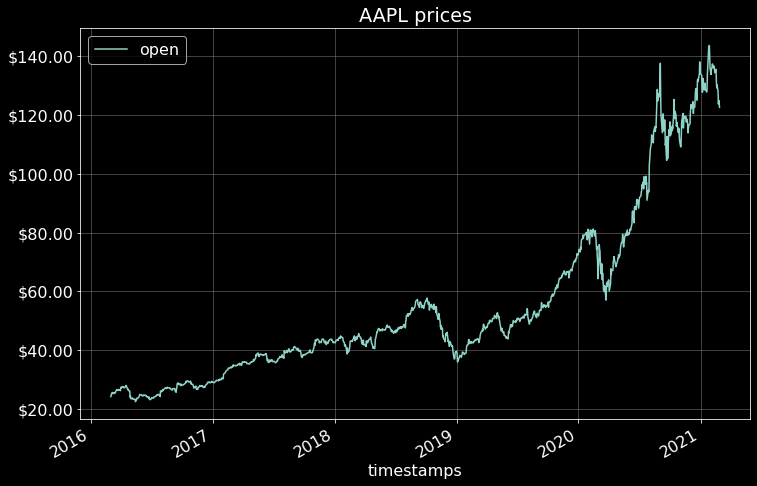

In [5]:
ticker = 'AAPL'
df = getStockData(ticker, "2017", "2020")

ax = df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Method for labeling price data as BUY, HOLD, or SELL

*SELL = 0, BUY = 1, HOLD = 2*


*Parameters:*

    df: Pandas DataFrame
    col_name: Name of the column in df that will be used to determine labels
        - availiable names: "open", "close", "high", "low"
    window_size: How large the window size will be when determining labels
        - default size: 11

In [6]:
from tqdm.auto import tqdm

def create_labels(df, col_name, window_size=11):

    row_counter = 0
    total_rows = len(df)
    # Creates a 1 x N numpy array
    labels = np.zeros(total_rows)
    # Makes all the entries in labels array equal to nan
    labels[:] = np.nan
    # Sets up a progress bar
    pbar = tqdm(total=total_rows)

    while row_counter < total_rows:

        # Stalls labeling calculation until the row_counter is at least as big as the window_size
        if row_counter >= window_size - 1:
            window_begin = row_counter - (window_size - 1)
            window_end = row_counter
            window_middle = (window_begin + window_end) // 2 # Cast as int

            min_ = np.inf
            min_index = -1
            max_ = -np.inf
            max_index = -1
            for i in range(window_begin, window_end + 1):
                # Selected value at 'i' index in column with name equal to col_name variable
                price = df.iloc[i][col_name]
                if price < min_:
                    # Finds the smallest value in the window
                    # 'min_' is initially set to infinity
                    min_ = price
                    # Saves the index of the lowest value
                    min_index = i
                if price > max_:
                    # Finds the largest value in the window
                    # 'max_' is initially set to -infinity
                    max_ = price
                    # Saves the index of the largest value
                    max_index = i

            if max_index == window_middle:
                # Sets label to SELL
                labels[window_middle] = 0
            elif min_index == window_middle:
                # Sets label to BUY
                labels[window_middle] = 1
            else:
                # Sets label to HOLD
                labels[window_middle] = 2

        row_counter = row_counter + 1
        pbar.update(1)


    pbar.close()
    return labels

# Plotting of prediction labels using 'close' column

Text(0.5, 1.0, 'Prediction Labels')

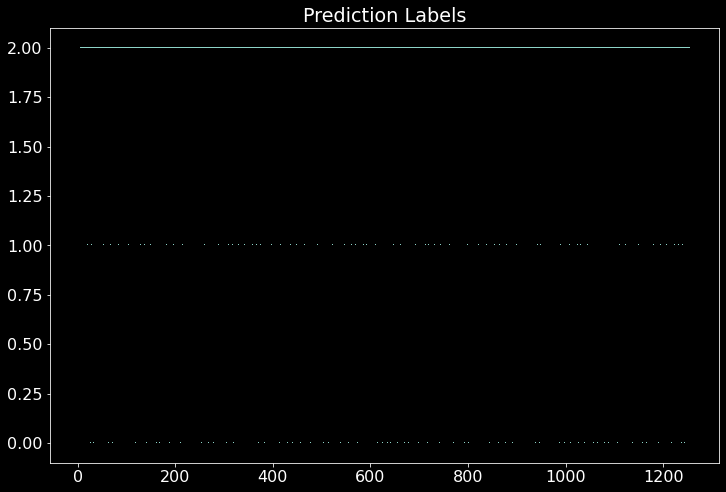

In [7]:
labels = create_labels(df, 'close')

fig = plt.figure()
plt.plot(labels, ',')
plt.title('Prediction Labels')


# Creating 15 indicators for improved quality of the dataset

#Using type oscillating indicators

In [23]:

#Moving Average Convergance Divergence Momentum 
#Indicator to identify buying properties 
def calculate_macd(df):
	df['12-Day EMA'] = df['close'].ewm(span=12).mean()
	df['26-Day EMA'] = df['close'].ewm(span=26).mean()
	df['MACD'] = df['12-Day EMA'] - df['26-Day EMA']
	df['Signal Line'] = df['MACD'].ewm(span=9).mean()
	
def plot_macd(df, title="MACD"):
	plt.figure()
	ax = df[['MACD', "Signal Line"]].plot(title=title)
	ax.set_xlabel("Days",)
	ax.set_ylabel("MACD")
 

#Relative Strength Index indicator that measures if stock is being traded above or below its true value 
def calculate_rsi(df):
	diff = df['close'].diff()
	up, down = diff.copy(), diff.copy()
	up[up < 0] = 0
	down[down > 0] = 0
	df['Upward Movement'] = up
	df['Downward Movement'] = abs(down)
	df['Avg. 11-Day Up Closes'] = df['Upward Movement'].rolling(11).mean() # using 11 day periods
	df['Avg. 11-Day Down Closes'] = df['Downward Movement'].rolling(11).mean() # using 11 day periods
	df['Relative Strength'] = df['Avg. 11-Day Up Closes'] / df['Avg. 11-Day Down Closes']
	df['RSI'] = 100 - (100/(1+df['Relative Strength']))
 
def plot_rsi(df, title="RSI"):
	plt.figure()
	ax = df['RSI'].plot(title=title, color="green")
	ax.set_xlabel("Days")
	ax.set_ylabel("RSI")
	plt.axhline(y=30,color='blue') # line presents threshold of overvalued stock 
	plt.axhline(y=70,color='red') # line represent threshold of undervalued stock 

#Stochastic Oscillator Indicator is an indicator for the speed and momentum of a price 
def calculate_sr(df):
  df['11-high'] = df['high'].rolling(11).max()
  df['11-low'] = df['low'].rolling(11).min()
  df['%K'] = (df['close']-df['11-low'])*100/(df['11-high'] - df['11-low'])
  df['%D'] =df['%K'].rolling(3).mean()
def plot_sr(df,title='SR'):
  plt.figure()
  ax = df[['%K','%D']].plot()
  df['close'].plot(ax=ax, secondary_y=True)
  ax.axhline(20, linestyle='--', color="r") # threshold for overbought range
  ax.axhline(80, linestyle="--", color="r") # threshold for oversold range
  plt.show()

# Average True range indicator that measures volatility of the stock 
def calculate_atr(df):
  data = df.copy()
  high = df['high']
  low = df['low']
  close = df['close']
  df['tr0'] = abs(high - low)
  df['tr1'] = abs(high - close.shift())
  df['tr2'] = abs(low - close.shift())
  df['TR'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
  df['ATR'] = df['TR'].ewm(alpha=1/11,adjust=False).mean()

  # Plot shows the voltality of the stock
  # when voltatily is low buy stock. 
def plot_atr(df,title='ATR'):
  plt.figure()
  ax = df['ATR'].plot(title=title,color="red")
  ax.set_xlabel("Days")
  ax.set_ylabel("ATR")

  # Double exponential moving average indicates trends but this faster MA helps determine fast trends in stock 
def calculate_dema(df):
  multiplier = (2/(11+1))
  df['dema1'] = sum(df['close'],11)
  df['DEMA'] = (df['close'] * multiplier) + (df['dema1'] * (1-multiplier))
def plot_dema(df,title='DEMA'):
  plt.figure()
  ax = df['DEMA'].plot(title=title,color="red")
  ax.set_xlabel("Days")
  ax.set_ylabel("DEMA")

<Figure size 864x576 with 0 Axes>

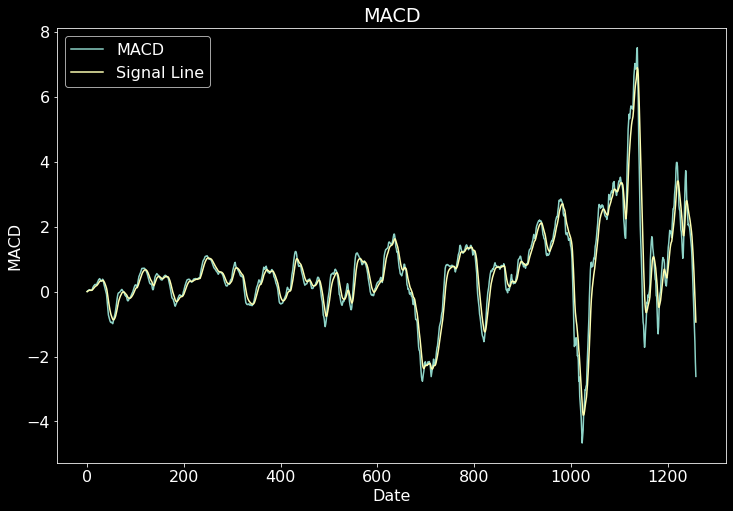

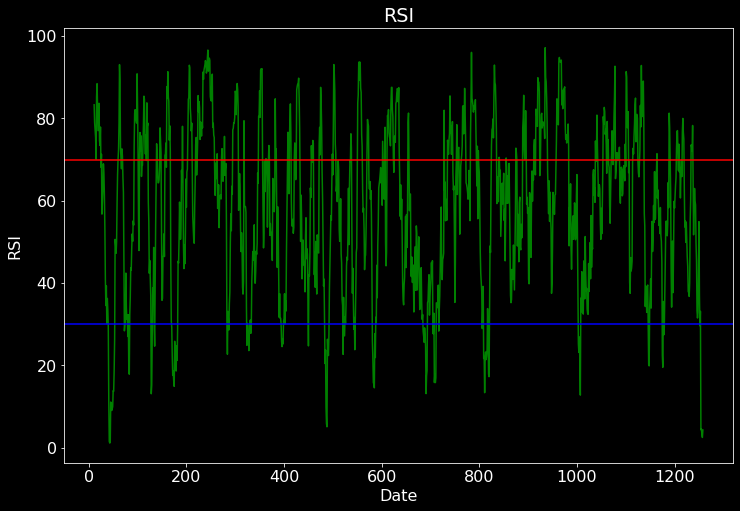

<Figure size 864x576 with 0 Axes>

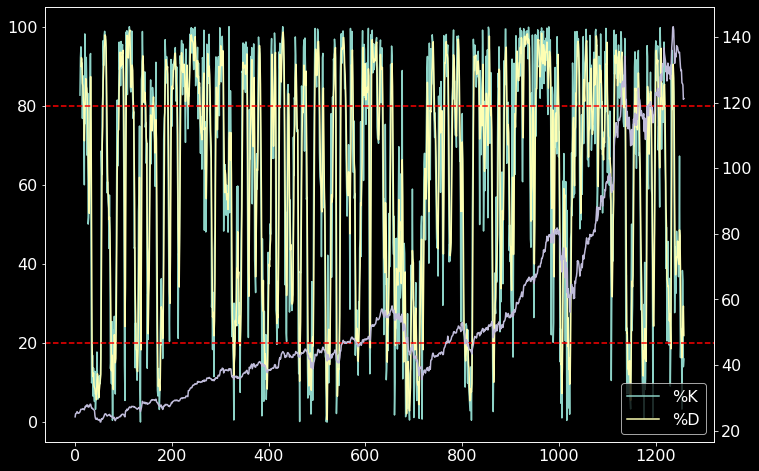

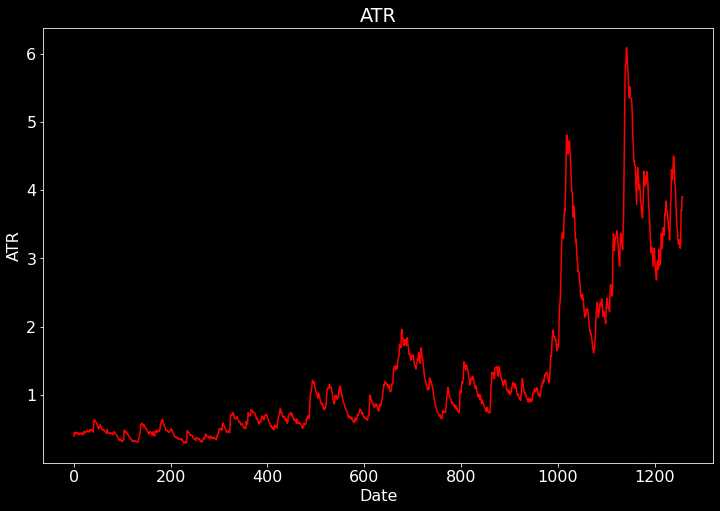

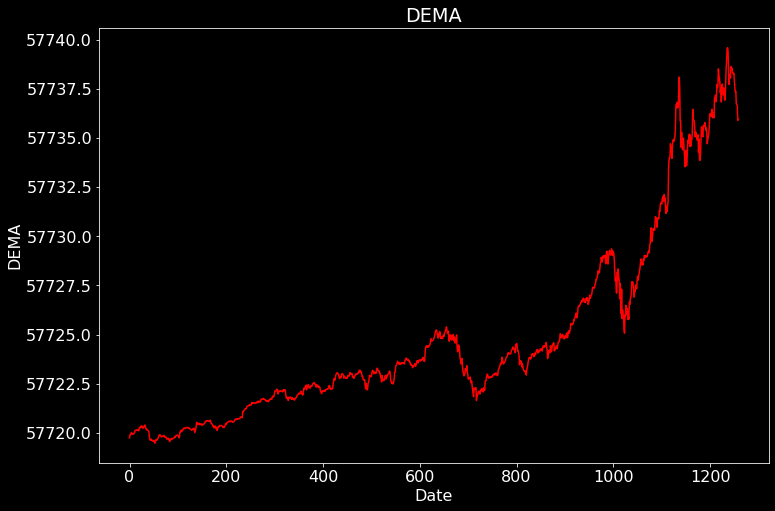

In [24]:
calculate_macd(df)
#this graph shows that when the MACD line falls below or above a signal line indicating when to buy or sell 
#above the signal line bullish stock price-> rising price 
#below the signal line bearish stock price-> falling stock price 
plot_macd(df)

calculate_rsi(df)
plot_rsi(df)


#when %K is above %D the it signals buy 
#when %K is below %D then it  signals sell 
calculate_sr(df)
plot_sr(df)

calculate_atr(df)
plot_atr(df)

calculate_dema(df)
plot_dema(df)

In [68]:
# Boiling Band indicator indicates the 
def calculate_bb(df):
  df['MA11'] = df['close'].rolling(window=11).mean()
  df['11STD'] = df['close'].rolling(window=11).std()
  df['Upper'] = df['MA11'] + (df['11STD'] *2)
  df['Lower'] = df['MA11'] - (df['11STD'] *2)
  df['BB'] = df[['close','MA11','Upper','Lower']].max(axis=1)
def plot_bb(df,title='BB'):
  plt.figure()
  ax = df[['BB','Upper','Lower']].plot(title=title)
  ax.set_xlabel("Days")
  ax.set_ylabel("BB")
# Williams %R indicator helps indicate overbought and oversold stocks. 
# reverse values of SRI 
def calculate_WR(df):
  df['11-high'] = df['high'].rolling(11).max()
  df['11-low'] = df['low'].rolling(11).min()
  df['wr'] = (df['11-high']-df['close'])/(df['11-high']-df['11-low'])*-100
  df['WR'] = df['wr'].rolling(3).mean()


def plot_WR(df,title='WR'):
  plt.figure()
  ax = df['WR'].plot(title=title)
  ax.set_xlabel("Days")
  ax.set_ylabel("WR")
  ax.axhline(-20, linestyle='--', color="r") # threshold for overbought range
  ax.axhline(-80, linestyle="--", color="r") # threshold for oversold range




<Figure size 864x576 with 0 Axes>

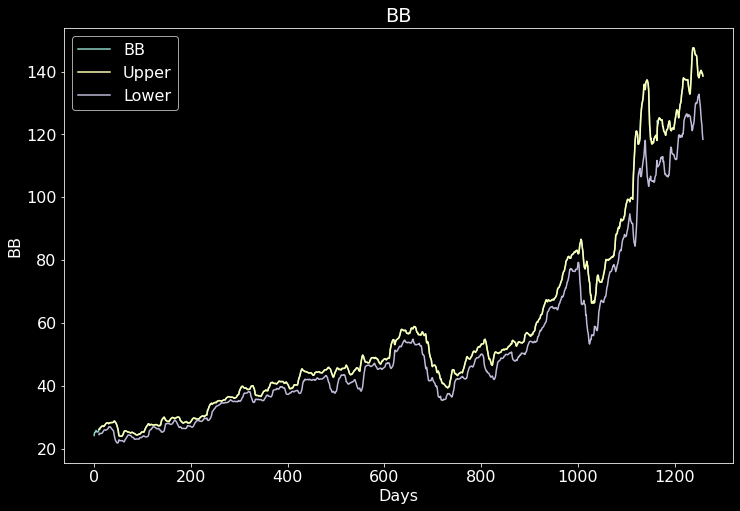

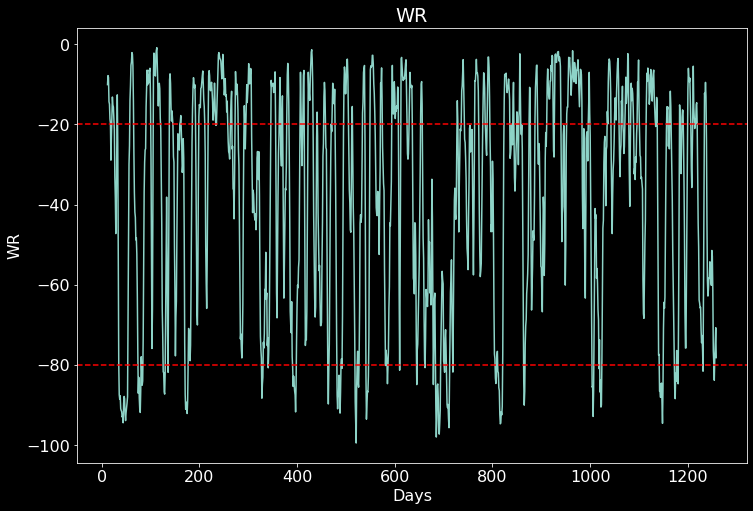

In [69]:
calculate_bb(df)
plot_bb(df)

calculate_WR(df)
plot_WR(df)